In [1]:
from netCDF4 import Dataset
from collections import defaultdict, namedtuple
import datetime
import numpy as np
import seaborn as sns
sns.set()
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import math
import os
import csv

find closest observatories

In [43]:
eddy_locs = defaultdict(set)
atm_locs = defaultdict(set)

for fname in os.listdir('data/arm'):
    ds = Dataset('data/arm/' + fname)
    loc = (ds['lat'][0], ds['lon'][0])

    sit = fname.split('.')[0]
    if 'sgp30qce' in fname:
        eddy_locs[loc].add(sit)
    elif 'thwaps' in fname:
        atm_locs[loc].add(sit)


dss, min_dist = None, 100000000
for el in eddy_locs.keys():
    for al in atm_locs.keys():
        dist = (el[0] - al[0])**2 + (el[1] - al[1])**2
        if dist < min_dist:
            min_dist = dist
            dss = el, al

min_dist, dss, eddy_locs[dss[0]], atm_locs[dss[1]]

(0.0049999237089650705,
 ((36.061, -99.134), (36.071, -99.204)),
 {'sgp30qcecorE16'},
 {'sgpthwapsB4'})

find common measurement date

In [36]:
obs1, obs2 = list(eddy_locs[dss[0]])[0], list(atm_locs[dss[1]])[0]

dates1, dates2 = set(), set()
for fname in os.listdir('data/arm'):
    date = fname.split('.')[2]
    if obs1 in fname and :
        dates1.add(date)
    elif obs2 in fname:
        dates2.add(date)


common = dates1 & dates2
date = common.pop()
print('%d dates in common, picking %s' % (len(common), date))

for fname in os.listdir('data/arm'):
    if date not in fname:
        continue

    if obs1 in fname :
        fluxds = Dataset('data/arm/' + fname)
        print('loaded', fname)
    elif obs2 in fname:
        atmds = Dataset('data/arm/' + fname)
        print('loaded', fname)

2243 dates in common, picking 20080628
loaded sgp30qcecorE16.s1.20080628.000000.cdf
loaded sgpthwapsB4.b1.20080628.000000.cdf


In [13]:
fluxds = Dataset('data/arm/sgp30ecorE16.b1.20080626.000000.cdf')
windds = Dataset('data/arm/sgpthwapsB4.b1.20080628.000000.cdf')

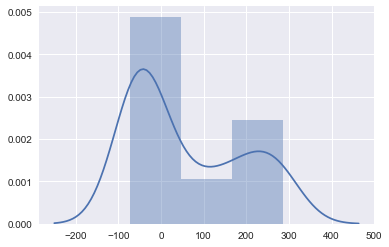

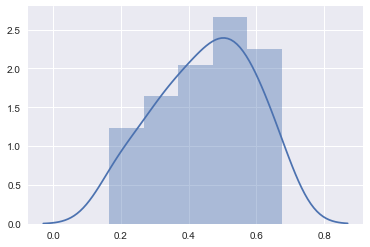

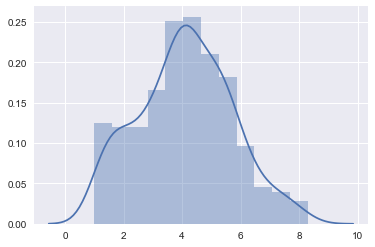

In [15]:
sns.distplot(fluxds['h'][:])
plt.show()
sns.distplot(fluxds['ustar'][:])
plt.show()
sns.distplot(windds['wspd'][:])
plt.show()

In [38]:
RowRecord = namedtuple('RowRecord', [
    'h', 'ustar', 'u', 't', 'z', 'tt', 'lval', 'zL', 'dudz', 'phi'
])

def compute_row(windds, fluxds, tt):
    h = fluxds['h'][tt]
    ustar = fluxds['ustar'][tt]
    u = windds['wspd'][tt]
    t = windds['temp'][tt] + 273.15
    z = 4  # wind measurement at 4m, TODO check this

    if abs(h) < 10 or u < 1 or ustar < 0.1 or any(
        isinstance(x, np.ma.core.MaskedConstant) for x in [h, ustar, u, t]
    ):
        return None
    
    lval = -ustar**3 * t * 1.005 * 1.21 / (0.4 * 9.81 * h)
    zL = z / lval

    dudz = u / z
    phi = dudz * 0.4 * z / ustar

    return RowRecord(h=h, ustar=ustar, u=u, t=t, z=z, lval=lval,
                     zL=zL, dudz=dudz, phi=phi, tt=tt)


def process_dataset(month):
    try:
        fluxds = Dataset('data/arm/sgp30ecorE16.b1.%s.000000.cdf' % month)
        windds = Dataset('data/arm/sgpthwapsB4.b1.%s.000000.cdf' % month)
    except Exception as exc:
        return

    try:
        t1, t2 = fluxds['time'][:], windds['time'][:]
    except:
        print('time not in', month)
        return

    i = j = 0

    # you used to be able to index data by time
    # dunno dafuq happened w/ dis shit
    while i < len(t1) and j < len(t2):
        while i < len(t1) and t1[i] < t2[j]:
            i += 1

        if i >= len(t1):
            break
        
        while j < len(t2) and t2[j] < t1[i]:
            j += 1

        if j >= len(t2):
            break

        if t1[i] == t2[j]:
            row = compute_row(windds, fluxds, i)
            if row:
                yield row

            i += 1
            j += 1


import findspark
findspark.init()

from pyspark import SparkContext, SparkConf

sc = SparkContext(conf=SparkConf().setMaster('local[7]').set('spark.driver.memory', '14g'))
all_months = set(fname.split('.')[2] for fname in os.listdir('data/arm'))

try:
    df_rows = (sc.parallelize(list(all_months))
                   .flatMap(process_dataset).collect())
finally:
    sc.stop()

df = pd.DataFrame(df_rows)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
h,71207.0,63.749745,141.542177,-290.899994,-41.835001,-10.490000,152.100006,1057.000000
ustar,71207.0,0.397625,0.173671,0.100000,0.264000,0.378900,0.512600,1.301000
u,71207.0,3.919166,2.052444,1.000000,2.280000,3.482000,5.202000,15.690000
t,71207.0,288.450879,10.737609,257.450000,280.054500,289.209999,297.400000,314.760001
z,71207.0,4.000000,0.000000,4.000000,4.000000,4.000000,4.000000,4.000000
tt,71207.0,24.696631,13.917443,0.000000,12.000000,26.000000,37.000000,47.000000
lval,71207.0,0.016361,0.323736,-6.092366,-0.053333,0.004068,0.070709,12.128026
zL,71207.0,-26.364217,380.545857,-18215.912946,-73.447364,2.419377,57.794440,3038.272619
dudz,71207.0,0.979791,0.513111,0.250000,0.570000,0.870500,1.300500,3.922500
phi,71207.0,4.498440,2.808400,0.449866,2.614778,3.940646,5.580733,42.019048


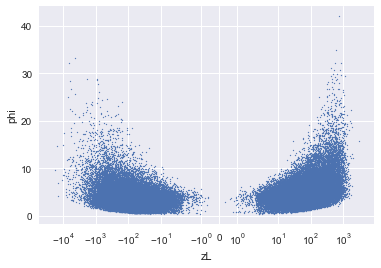

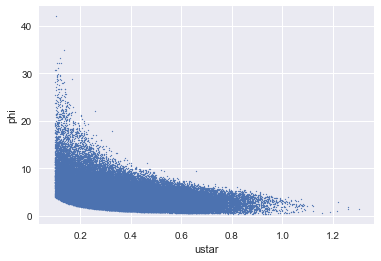

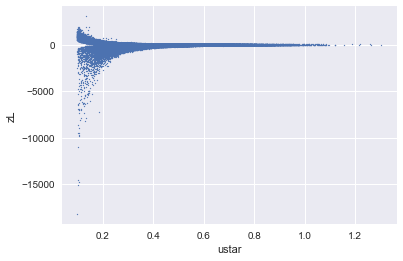

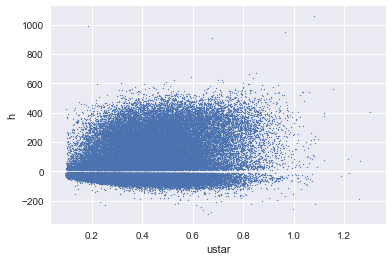

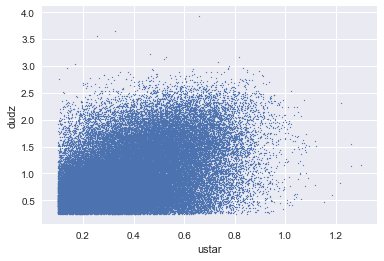

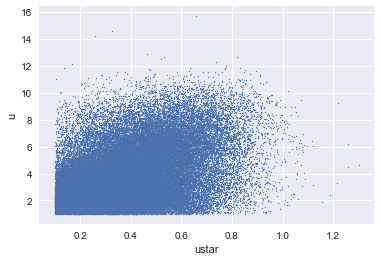

In [50]:
df.plot.scatter('zL', 'phi', s=1)
plt.xscale('symlog')
df.plot.scatter('ustar', 'phi', s=1)
df.plot.scatter('ustar', 'zL', s=1)
df.plot.scatter('ustar', 'h', s=1)
df.plot.scatter('ustar', 'dudz', s=1)
df.plot.scatter('ustar', 'u', s=1)